# Problem Statement Health Insurance Lead Prediction

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

    Demographics (city, age, region etc.)
    Information regarding holding policies of the customer
    Recommended Policy Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

sns.set()
pd.options.display.max_columns = 100

In [2]:
raw_data = pd.read_csv("train_Df64byy.csv")
raw_data.shape

(50882, 14)

In [3]:
# split train and validation
train, valid = train_test_split(raw_data, test_size=0.33, random_state=42,stratify=raw_data['Response'])
train = train.copy()
valid = valid.copy()
print(f"Train Shape {train.shape}")
print(f"Valid Shape {valid.shape}")

Train Shape (34090, 14)
Valid Shape (16792, 14)


In [4]:
train.head(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
18517,18518,C19,2270,Owned,Individual,65,65,No,X5,9.0,3.0,2,19080.0,0
21636,21637,C7,1625,Owned,Individual,69,69,No,X2,2.0,4.0,15,14504.0,0
2743,2744,C33,912,Owned,Individual,52,52,No,NaN,12.0,3.0,8,17640.0,1


In [5]:
train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

In [6]:
object_type = ['ID','Region_Code','Holding_Policy_Type','Reco_Policy_Cat']
for col in object_type:
    train[col] = train[col].astype(np.object)    

In [7]:
train.describe(include=np.object).T

,count,unique,top,freq
ID,34090,34090,50882,1
City_Code,34090,36,C1,6079
Region_Code,34090,5029,1,62
Accomodation_Type,34090,2,Owned,18729
Reco_Insurance_Type,34090,2,Individual,27096
Is_Spouse,34090,2,No,28418
Health Indicator,26311,9,X1,8803
Holding_Policy_Duration,20500,15,1.0,3002
Holding_Policy_Type,20500,4,3,8867
Reco_Policy_Cat,34090,22,22,4402


In [8]:
train.describe()

,Upper_Age,Lower_Age,Reco_Policy_Premium,Response
count,34090.000000,34090.000000,34090.000000,34090.000000
mean,44.915342,42.770549,14215.008043,0.239953
std,17.323759,17.328425,6598.390147,0.427061
min,18.000000,16.000000,2280.000000,0.000000
25%,28.000000,27.000000,9248.000000,0.000000
50%,44.000000,40.000000,13216.000000,0.000000
75%,60.000000,57.000000,18172.000000,0.000000
max,75.000000,75.000000,43046.400000,1.000000


In [9]:
na_col = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
for col in na_col:
    train[col] = train[col].fillna('na')

In [10]:
train['Response'].value_counts(normalize=True)

0    0.760047
1    0.239953
Name: Response, dtype: float64

In [11]:
train['City_Code'].value_counts(normalize=True).cumsum()

C1     0.178322
C2     0.330625
C3     0.427750
C4     0.499619
C9     0.541625
C6     0.580141
C7     0.616280
C8     0.651951
C10    0.683045
C5     0.710414
C15    0.733236
C17    0.755940
C16    0.778351
C11    0.800645
C13    0.820006
C20    0.837430
C19    0.854825
C12    0.871135
C18    0.886800
C14    0.901936
C21    0.915635
C23    0.927134
C24    0.938105
C26    0.948313
C22    0.958404
C29    0.966500
C25    0.973951
C33    0.979818
C27    0.985685
C28    0.990701
C32    0.993928
C34    0.996597
C35    0.997741
C30    0.998827
C36    0.999648
C31    1.000000
Name: City_Code, dtype: float64

In [12]:
train['Region_Code'].nunique()

5029

In [13]:
train['age_gap'] = (train['Upper_Age'] == train['Lower_Age'])
train['age_gap'].value_counts(normalize=True)

True     0.794837
False    0.205163
Name: age_gap, dtype: float64

In [14]:
train['mid_age'] = (train['Upper_Age'] + train['Lower_Age'])/2

In [15]:
train['Health Indicator'].value_counts(normalize=True).cumsum()

X1    0.258228
na    0.486418
X2    0.687885
X3    0.822206
X4    0.935260
X5    0.968759
X6    0.993517
X7    0.997448
X8    0.998856
X9    1.000000
Name: Health Indicator, dtype: float64

In [16]:
# health_ind = ['X1','na','X2','X3']
# train['new_health_ind'] =  train['Health Indicator'].apply(lambda x : x if x in health_ind else 'other')
# train['new_health_ind'].value_counts(normalize=True)

In [17]:
train['Holding_Policy_Duration'].value_counts(normalize=True)

na      0.398651
1.0     0.088061
2.0     0.083896
14+     0.082752
3.0     0.070255
4.0     0.055001
5.0     0.046465
6.0     0.037489
7.0     0.032678
8.0     0.025902
9.0     0.022265
10.0    0.015987
11.0    0.010766
12.0    0.010560
13.0    0.010003
14.0    0.009270
Name: Holding_Policy_Duration, dtype: float64

In [18]:
train['policy_duration'] = train['Holding_Policy_Duration'].replace({'na':'0','14+':'14'}).astype(float)
train['policy_duration'].describe()

count    34090.000000
mean         3.603579
std          4.546766
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max         14.000000
Name: policy_duration, dtype: float64

In [19]:
train['entry_age'] = train['mid_age']-train['policy_duration']
train['entry_age'].describe()

count    34090.000000
mean        40.239366
std         15.909633
min         11.500000
25%         26.000000
50%         37.000000
75%         53.000000
max         75.000000
Name: entry_age, dtype: float64

In [20]:
train['Holding_Policy_Type'].value_counts(normalize=True)

na     0.398651
3.0    0.260106
1.0    0.159959
2.0    0.097917
4.0    0.083368
Name: Holding_Policy_Type, dtype: float64

In [21]:
train['Reco_Policy_Cat'].value_counts(normalize=True).cumsum()

22    0.129129
18    0.237694
21    0.336022
16    0.416603
17    0.491610
19    0.565679
20    0.627105
12    0.669757
1     0.708214
2     0.746377
14    0.780375
13    0.813259
15    0.844911
3     0.865415
5     0.885538
4     0.905104
6     0.921795
7     0.938252
11    0.954297
9     0.970226
10    0.985362
8     1.000000
Name: Reco_Policy_Cat, dtype: float64

In [22]:
# recom_policy = [22,18,21,16,17,19,20]
# train['new_reco_policy'] =  train['Reco_Policy_Cat'].apply(lambda x : str(x) if x in recom_policy else 'other')
# train['new_reco_policy'].value_counts(normalize=True)

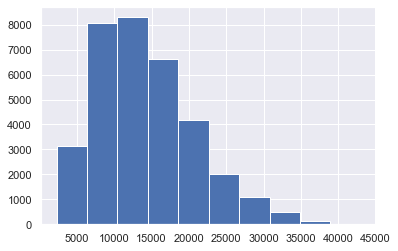

In [23]:
train['Reco_Policy_Premium'].hist()

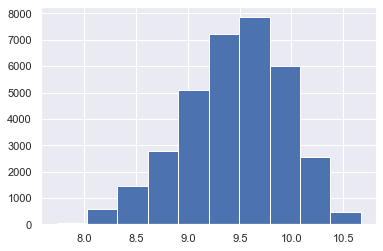

In [24]:
train['recom_prem'] = np.log(train['Reco_Policy_Premium'])
train['recom_prem'].hist()

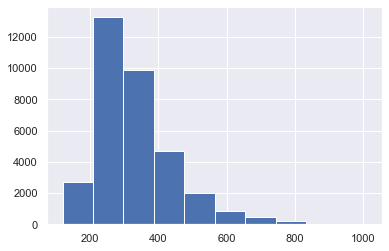

In [25]:
train['age_factor'] = train['Reco_Policy_Premium']/train['mid_age']
train['age_factor'].hist()

In [26]:
# train[train['new_city_code'] != 'other']['Region_Code'].value_counts(normalize=True).cumsum()

In [27]:
train.sample(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,age_gap,mid_age,policy_duration,entry_age,recom_prem,age_factor
39672,39673,C3,2797,Owned,Individual,55,55,No,X2,na,na,2,13024.0,1,True,55.0,0.0,55.0,9.474549,236.800000
20573,20574,C3,13,Owned,Individual,30,30,No,X1,3.0,1,12,7908.0,0,True,30.0,3.0,27.0,8.975630,263.600000
42260,42261,C3,2627,Owned,Individual,75,75,No,X3,14+,1,18,20672.0,0,True,75.0,14.0,61.0,9.936535,275.626667


In [28]:
train['Holding_Policy_Type'] = train['Holding_Policy_Type'].astype(str)

In [29]:
train.head(1)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,age_gap,mid_age,policy_duration,entry_age,recom_prem,age_factor
18517,18518,C19,2270,Owned,Individual,65,65,No,X5,9.0,3.0,2,19080.0,0,True,65.0,9.0,56.0,9.856396,293.538462


In [30]:
key_col = ['City_Code','Region_Code','Accomodation_Type','Reco_Insurance_Type','Health Indicator',
          'Holding_Policy_Type','Reco_Policy_Cat']

cat_col = ['City_Code','Accomodation_Type','Reco_Insurance_Type','Health Indicator','Holding_Policy_Type',
          'Reco_Policy_Cat','Is_Spouse']

num_col = ['policy_duration','Reco_Policy_Premium','mid_age','entry_age','age_factor']

featured_data = {}
for key in key_col:
    print(f"processing key {key}......")
    interim_grp = []
    
    for cat in cat_col:
        
        
        if cat == key:
            continue
            
        print(f"\tprocessing cat {cat}......")
        
        grp = train.groupby([key,cat]).size().unstack(fill_value=0)
        grp = grp.div(grp.sum(axis=1),axis=0)
        
        for grp_col in grp.columns:
            grp.rename({grp_col:f'{key}_{grp_col}_per'},axis=1,inplace=True)
        
        grp = grp.reset_index()
        interim_grp.append(grp)
        
    print(f"\tprocessing numeric ......")
    
    grp = train.groupby([key])[num_col].mean()
        
    for grp_col in grp.columns:
        grp.rename({grp_col:f'{key}_{grp_col}_mean'},axis=1,inplace=True)
        
    grp = grp.reset_index()    
    master = grp.copy()
    for interim in interim_grp:
        master = master.merge(interim,how='left',on=[key])
    
    featured_data[key] = master

processing key City_Code......
	processing cat Accomodation_Type......
	processing cat Reco_Insurance_Type......
	processing cat Health Indicator......
	processing cat Holding_Policy_Type......
	processing cat Reco_Policy_Cat......
	processing cat Is_Spouse......
	processing numeric ......
processing key Region_Code......
	processing cat City_Code......
	processing cat Accomodation_Type......
	processing cat Reco_Insurance_Type......
	processing cat Health Indicator......
	processing cat Holding_Policy_Type......
	processing cat Reco_Policy_Cat......
	processing cat Is_Spouse......
	processing numeric ......
processing key Accomodation_Type......
	processing cat City_Code......
	processing cat Reco_Insurance_Type......
	processing cat Health Indicator......
	processing cat Holding_Policy_Type......
	processing cat Reco_Policy_Cat......
	processing cat Is_Spouse......
	processing numeric ......
processing key Reco_Insurance_Type......
	processing cat City_Code......
	processing cat Acco

In [31]:
for key in featured_data:
    train = train.merge(featured_data[key],how='left',on=key)

In [32]:
train.shape

(34090, 531)

In [33]:
train.sample(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,age_gap,mid_age,policy_duration,entry_age,recom_prem,age_factor,City_Code_policy_duration_mean,City_Code_Reco_Policy_Premium_mean,City_Code_mid_age_mean,City_Code_entry_age_mean,City_Code_age_factor_mean,City_Code_Owned_per,City_Code_Rented_per,City_Code_Individual_per,City_Code_Joint_per,City_Code_X1_per,City_Code_X2_per,City_Code_X3_per,City_Code_X4_per,City_Code_X5_per,City_Code_X6_per,City_Code_X7_per,City_Code_X8_per,City_Code_X9_per,City_Code_na_per_x,City_Code_1.0_per,City_Code_2.0_per,City_Code_3.0_per,City_Code_4.0_per,City_Code_na_per_y,City_Code_1_per,City_Code_2_per,City_Code_3_per,City_Code_4_per,City_Code_5_per,City_Code_6_per,...,Reco_Policy_Cat_C16_per,Reco_Policy_Cat_C17_per,Reco_Policy_Cat_C18_per,Reco_Policy_Cat_C19_per,Reco_Policy_Cat_C2_per,Reco_Policy_Cat_C20_per,Reco_Policy_Cat_C21_per,Reco_Policy_Cat_C22_per,Reco_Policy_Cat_C23_per,Reco_Policy_Cat_C24_per,Reco_Policy_Cat_C25_per,Reco_Policy_Cat_C26_per,Reco_Policy_Cat_C27_per,Reco_Policy_Cat_C28_per,Reco_Policy_Cat_C29_per,Reco_Policy_Cat_C3_per,Reco_Policy_Cat_C30_per,Reco_Policy_Cat_C31_per,Reco_Policy_Cat_C32_per,Reco_Policy_Cat_C33_per,Reco_Policy_Cat_C34_per,Reco_Policy_Cat_C35_per,Reco_Policy_Cat_C36_per,Reco_Policy_Cat_C4_per,Reco_Policy_Cat_C5_per,Reco_Policy_Cat_C6_per,Reco_Policy_Cat_C7_per,Reco_Policy_Cat_C8_per,Reco_Policy_Cat_C9_per,Reco_Policy_Cat_Owned_per,Reco_Policy_Cat_Rented_per,Reco_Policy_Cat_Individual_per,Reco_Policy_Cat_Joint_per,Reco_Policy_Cat_X1_per,Reco_Policy_Cat_X2_per,Reco_Policy_Cat_X3_per,Reco_Policy_Cat_X4_per,Reco_Policy_Cat_X5_per,Reco_Policy_Cat_X6_per,Reco_Policy_Cat_X7_per,Reco_Policy_Cat_X8_per,Reco_Policy_Cat_X9_per,Reco_Policy_Cat_na_per_x,Reco_Policy_Cat_1.0_per,Reco_Policy_Cat_2.0_per,Reco_Policy_Cat_3.0_per,Reco_Policy_Cat_4.0_per,Reco_Policy_Cat_na_per_y,Reco_Policy_Cat_No_per,Reco_Policy_Cat_Yes_per
24131,43201,C15,2884,Owned,Individual,51,51,No,X3,na,na,2,16016.0,0,True,51.0,0.0,51.0,9.681344,314.039216,3.638817,15488.203599,44.607326,40.968509,354.054162,0.528278,0.471722,0.727506,0.272494,0.244216,0.179949,0.134961,0.123393,0.048843,0.033419,0.002571,0.005141,0.002571,0.224936,0.267352,0.083548,0.232648,0.055270,0.361183,0.084833,0.050129,0.000000,0.001285,0.008997,0.005141,...,0.021522,0.051499,0.037663,0.076864,0.066872,0.006149,0.011530,0.009224,0.000000,0.019985,0.013836,0.016910,0.002306,0.007686,0.006149,0.156802,0.000000,0.000000,0.003075,0.025365,0.001537,0.003843,0.000000,0.065334,0.013836,0.032283,0.032283,0.051499,0.059954,0.439662,0.560338,0.839354,0.160646,0.253651,0.171407,0.166026,0.092237,0.029208,0.043044,0.001537,0.003075,0.001537,0.238278,0.325135,0.067640,0.139124,0.031514,0.436587,0.881630,0.118370
9934,8058,C2,21,Owned,Individual,47,47,No,X1,14+,3.0,21,9616.0,1,True,47.0,14.0,33.0,9.171184,204.595745,4.312211,15178.819877,45.668529,41.356317,338.327013,0.575886,0.424114,0.794492,0.205508,0.239407,0.208975,0.122304,0.133860,0.039484,0.020609,0.005393,0.000770,0.000193,0.229006,0.079353,0.065871,0.363444,0.130393,0.360940,0.001926,0.016757,0.130971,0.000000,0.000000,0.000193,...,0.018198,0.004177,0.008950,0.002088,0.165573,0.018795,0.007757,0.028938,0.020585,0.002387,0.011933,0.013723,0.006563,0.011337,0.008950,0.095465,0.000298,0.000597,0.005072,0.004773,0.004773,0.002088,0.005668,0.059964,0.026551,0.049224,0.049821,0.055788,0.049224,0.584726,0.415274,0.784905,0.215095,0.254475,0.220167,0.127983,0.107995,0.029535,0.019690,0.003580,0.000597,0.001193,0.234785,0.091289,0.063246,0.396181,0.059368,0.389916,0.822494,0.177506
29172,42277,C4,897,Owned,Individual,32,32,No,na,na,na,16,12060.0,0,True,32.0,0.0,32.0,9.397649,376.875000,2.930204,12564.174286,41.294898,38.364694,309.932134,0.527755,0.472245,0.864082,0.135918,0.288980,0.193469,0.159592,0.080408,0.020816,0.033469,0.001224,0.001224,0.0012

In [34]:
drop_col = ['ID','Region_Code','Holding_Policy_Duration','Reco_Policy_Premium','Response']
x_train = train.drop(drop_col,axis=1)
x_train.shape

(34090, 526)

In [35]:
x_train.columns[x_train.dtypes == np.object]

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat'],
      dtype='object')

In [36]:
one_hot_cols = ['City_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health Indicator',
               'Reco_Policy_Cat','Holding_Policy_Type','age_gap']

cat_encoder = OneHotEncoder(handle_unknown ='ignore')
cat_array = cat_encoder.fit_transform(train[one_hot_cols])
one_hot = pd.DataFrame(cat_array.todense(),index=train.index,columns=cat_encoder.get_feature_names())


for idx, col in enumerate(one_hot_cols):
    one_hot.columns = one_hot.columns.str.replace(f"x{idx}",f"{col}")

one_hot.head(3)

,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Health Indicator_na,Reco_Policy_Cat_1,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Holding_Policy_Type_1.0,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_False,age_gap_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [37]:
num_col = x_train.drop(one_hot_cols,axis=1).columns
num_col

Index(['Upper_Age', 'Lower_Age', 'mid_age', 'policy_duration', 'entry_age',
       'recom_prem', 'age_factor', 'City_Code_policy_duration_mean',
       'City_Code_Reco_Policy_Premium_mean', 'City_Code_mid_age_mean',
       ...
       'Reco_Policy_Cat_X8_per', 'Reco_Policy_Cat_X9_per',
       'Reco_Policy_Cat_na_per_x', 'Reco_Policy_Cat_1.0_per',
       'Reco_Policy_Cat_2.0_per', 'Reco_Policy_Cat_3.0_per',
       'Reco_Policy_Cat_4.0_per', 'Reco_Policy_Cat_na_per_y',
       'Reco_Policy_Cat_No_per', 'Reco_Policy_Cat_Yes_per'],
      dtype='object', length=518)

In [38]:
scaler = StandardScaler()
num_array = scaler.fit_transform(train[num_col])
num_df = pd.DataFrame(num_array,index=train.index,columns=num_col)
num_df.head(3)

,Upper_Age,Lower_Age,mid_age,policy_duration,entry_age,recom_prem,age_factor,City_Code_policy_duration_mean,City_Code_Reco_Policy_Premium_mean,City_Code_mid_age_mean,City_Code_entry_age_mean,City_Code_age_factor_mean,City_Code_Owned_per,City_Code_Rented_per,City_Code_Individual_per,City_Code_Joint_per,City_Code_X1_per,City_Code_X2_per,City_Code_X3_per,City_Code_X4_per,City_Code_X5_per,City_Code_X6_per,City_Code_X7_per,City_Code_X8_per,City_Code_X9_per,City_Code_na_per_x,City_Code_1.0_per,City_Code_2.0_per,City_Code_3.0_per,City_Code_4.0_per,City_Code_na_per_y,City_Code_1_per,City_Code_2_per,City_Code_3_per,City_Code_4_per,City_Code_5_per,City_Code_6_per,City_Code_7_per,City_Code_8_per,City_Code_9_per,City_Code_10_per,City_Code_11_per,City_Code_12_per,City_Code_13_per,City_Code_14_per,City_Code_15_per,City_Code_16_per,City_Code_17_per,City_Code_18_per,City_Code_19_per,...,Reco_Policy_Cat_C16_per,Reco_Policy_Cat_C17_per,Reco_Policy_Cat_C18_per,Reco_Policy_Cat_C19_per,Reco_Policy_Cat_C2_per,Reco_Policy_Cat_C20_per,Reco_Policy_Cat_C21_per,Reco_Policy_Cat_C22_per,Reco_Policy_Cat_C23_per,Reco_Policy_Cat_C24_per,Reco_Policy_Cat_C25_per,Reco_Policy_Cat_C26_per,Reco_Policy_Cat_C27_per,Reco_Policy_Cat_C28_per,Reco_Policy_Cat_C29_per,Reco_Policy_Cat_C3_per,Reco_Policy_Cat_C30_per,Reco_Policy_Cat_C31_per,Reco_Policy_Cat_C32_per,Reco_Policy_Cat_C33_per,Reco_Policy_Cat_C34_per,Reco_Policy_Cat_C35_per,Reco_Policy_Cat_C36_per,Reco_Policy_Cat_C4_per,Reco_Policy_Cat_C5_per,Reco_Policy_Cat_C6_per,Reco_Policy_Cat_C7_per,Reco_Policy_Cat_C8_per,Reco_Policy_Cat_C9_per,Reco_Policy_Cat_Owned_per,Reco_Policy_Cat_Rented_per,Reco_Policy_Cat_Individual_per,Reco_Policy_Cat_Joint_per,Reco_Policy_Cat_X1_per,Reco_Policy_Cat_X2_per,Reco_Policy_Cat_X3_per,Reco_Policy_Cat_X4_per,Reco_Policy_Cat_X5_per,Reco_Policy_Cat_X6_per,Reco_Policy_Cat_X7_per,Reco_Policy_Cat_X8_per,Reco_Policy_Cat_X9_per,Reco_Policy_Cat_na_per_x,Reco_Policy_Cat_1.0_per,Reco_Policy_Cat_2.0_per,Reco_Policy_Cat_3.0_per,Reco_Policy_Cat_4.0_per,Reco_Policy_Cat_na_per_y,Reco_Policy_Cat_No_per,Reco_Policy_Cat_Yes_per
0,1.159388,1.282850,1.246082,1.186888,0.990649,0.831886,-0.324400,-0.781710,-0.027114,0.137353,0.323699,-0.219846,1.517202,-1.517202,-0.472105,0.472105,0.255182,0.548998,-1.598859,-0.100418,0.158262,1.498675,-1.504829,1.338282,2.308691,0.204846,3.309527,-0.162171,-2.772338,-1.508643,0.837774,3.990041,4.255178,-0.437319,-0.388181,-0.780433,-0.250771,-0.674928,-0.887812,-0.568224,-0.718799,-0.465878,-0.079497,-0.905955,-1.157042,-0.245435,0.160188,-2.092351,-1.46921,2.500188,...,-0.054526,1.120207,1.567660,2.124981,-0.466431,-0.706170,-0.094830,-0.089284,-0.773152,0.736179,1.155349,0.884287,-0.388739,0.403169,-0.151347,1.190756,-0.795613,-0.847171,-0.031927,3.902052,-0.127945,1.797111,-0.465999,-0.112754,-0.547433,-0.247629,-0.143444,0.878644,0.284471,-2.347672,2.347672,2.115622,-2.115622,-0.338927,-1.812684,1.718171,-1.191986,-0.444908,1.723469,-0.975038,1.102815,0.409802,1.012770,1.563684,-0.446719,-0.995585,-0.934626,1.887061,2.299884,-2.299884
1,1.390288,1.513688,1.481669,-0.352691,1.682064,0.270871,-1.058464,0.177659,0.081969,0.005434,-0.030226,0.514410,1.644686,-1.644686,-2.030291,2.030291,1.149378,1.375808,-1.939324,0.869226,-0.958043,0.513536,0.048876,1.252502,-0.195984,-1.296287,0.230229,2.046761,-0.875835,-1.042794,0.294697,0.022691,-0.132830,-0.437319,-0.307663,-0.308241,-0.235685,-0.641638,-0.543196,-0.365934,0.015267,-0.465878,-0.341842,0.748858,1.904781,2.986305,-0.758024,-1.221988,-1.23564,0.974436,...,1.523827,0.234423,1.063172,-0.091711,-0.067473,-0.162581,0.494996,-0.466387,-0.523897,0.315063,1.335046,-0.368662,1.079515,0.641944,0.379223,-0.551039,-0.116244,-0.847171,-0.093645,0.866092,-0.092200,-0.144643,-0.465999,0.183175,0.055077,0.973601,2.413064,-0.642468,0.156814,-1.106386,1.106386,-0.027719,0.027719,0.368640,-1.642102,1.610580,-1.591240,-1.743595,2.208767,-0.846192,2.134719,-1.192189,1.375424,0.056189,0.127816,-0.744778,0.485213,2.436688,0.689330,-0.689330
2,0.40

In [39]:
x_train = pd.concat([num_df,one_hot],axis=1,ignore_index=False,sort=False)
x_train.sample(2)

,Upper_Age,Lower_Age,mid_age,policy_duration,entry_age,recom_prem,age_factor,City_Code_policy_duration_mean,City_Code_Reco_Policy_Premium_mean,City_Code_mid_age_mean,City_Code_entry_age_mean,City_Code_age_factor_mean,City_Code_Owned_per,City_Code_Rented_per,City_Code_Individual_per,City_Code_Joint_per,City_Code_X1_per,City_Code_X2_per,City_Code_X3_per,City_Code_X4_per,City_Code_X5_per,City_Code_X6_per,City_Code_X7_per,City_Code_X8_per,City_Code_X9_per,City_Code_na_per_x,City_Code_1.0_per,City_Code_2.0_per,City_Code_3.0_per,City_Code_4.0_per,City_Code_na_per_y,City_Code_1_per,City_Code_2_per,City_Code_3_per,City_Code_4_per,City_Code_5_per,City_Code_6_per,City_Code_7_per,City_Code_8_per,City_Code_9_per,City_Code_10_per,City_Code_11_per,City_Code_12_per,City_Code_13_per,City_Code_14_per,City_Code_15_per,City_Code_16_per,City_Code_17_per,City_Code_18_per,City_Code_19_per,...,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Health Indicator_na,Reco_Policy_Cat_1,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Holding_Policy_Type_1.0,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_False,age_gap_True
4491,-0.514638,-0.390725,-0.461924,0.747008,-0.706461,-0.106657,0.040815,-0.781710,-0.027114,0.137353,0.323699,-0.219846,1.517202,-1.517202,-0.472105,0.472105,0.255182,0.548998,-1.598859,-0.100418,0.158262,1.498675,-1.504829,1.338282,2.308691,0.204846,3.309527,-0.162171,-2.772338,-1.508643,0.837774,3.990041,4.255178,-0.437319,-0.388181,-0.780433,-0.250771,-0.674928,-0.887812,-0.568224,-0.718799,-0.465878,-0.079497,-0.905955,-1.157042,-0.245435,0.160188,-2.092351,-1.46921,2.500188,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11243,1.736638,1.859945,1.835050,-0.792570,2.184912,0.858307,-0.640025,0.177659,0.081969,0.005434,-0.030226,0.514410,1.644686,-1.644686,-2.030291,2.030291,1.149378,1.375808,-1.939324,0.869226,-0.958043,0.513536,0.048876,1.252502,-0.195984,-1.296287,0.230229,2.046761,-0.875835,-1.042794,0.294697,0.022691,-0.132830,-0.437319,-0.307663,-0.308241,-0.235685,-0.641638,-0.543196,-0.365934,0.015267,-0.465878,-0.341842,0.748858,1.904781,2.986305,-0.758024,-1.221988,-1.23564,0.974436,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [40]:
x_train.shape,train.shape

((34090, 599), (34090, 531))

In [41]:
def prep_data(data,cat_encoder,scaler,featured_data,one_hot_cols,num_col):
    object_type = ['ID','Region_Code','Holding_Policy_Type','Reco_Policy_Cat']
    for col in object_type:
        data[col] = data[col].astype(np.object)  

    na_col = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
    for col in na_col:
        data[col] = data[col].fillna('na')

    data['age_gap'] = (data['Upper_Age'] == data['Lower_Age'])
    data['policy_duration'] = data['Holding_Policy_Duration'].replace({'na':'0','14+':'14'}).astype(float)
    data['recom_prem'] = np.log(data['Reco_Policy_Premium'])

    data['Holding_Policy_Type'] = data['Holding_Policy_Type'].astype(str)
    
    data['mid_age'] = (data['Upper_Age'] + data['Lower_Age'])/2
    data['age_factor'] = data['Reco_Policy_Premium']/data['mid_age']
    data['entry_age'] = data['mid_age']-data['policy_duration']
    
    for key in featured_data:
        data = data.merge(featured_data[key],how='left',on=key)

    cat_array = cat_encoder.transform(data[one_hot_cols])
    one_hot = pd.DataFrame(cat_array.todense(),index=data.index,columns=cat_encoder.get_feature_names())


    for idx, col in enumerate(one_hot_cols):
        one_hot.columns = one_hot.columns.str.replace(f"x{idx}",f"{col}")

   
    num_array = scaler.transform(data[num_col])
    num_df = pd.DataFrame(num_array,index=data.index,columns=num_col)

    x_data = pd.concat([num_df,one_hot],axis=1,ignore_index=False,sort=False)
#     x_data = poly.transform(x_data)
    
    return x_data

In [42]:
x_valid = prep_data(valid,cat_encoder,scaler,featured_data,one_hot_cols,num_col)
x_valid.head(3)

,Upper_Age,Lower_Age,mid_age,policy_duration,entry_age,recom_prem,age_factor,City_Code_policy_duration_mean,City_Code_Reco_Policy_Premium_mean,City_Code_mid_age_mean,City_Code_entry_age_mean,City_Code_age_factor_mean,City_Code_Owned_per,City_Code_Rented_per,City_Code_Individual_per,City_Code_Joint_per,City_Code_X1_per,City_Code_X2_per,City_Code_X3_per,City_Code_X4_per,City_Code_X5_per,City_Code_X6_per,City_Code_X7_per,City_Code_X8_per,City_Code_X9_per,City_Code_na_per_x,City_Code_1.0_per,City_Code_2.0_per,City_Code_3.0_per,City_Code_4.0_per,City_Code_na_per_y,City_Code_1_per,City_Code_2_per,City_Code_3_per,City_Code_4_per,City_Code_5_per,City_Code_6_per,City_Code_7_per,City_Code_8_per,City_Code_9_per,City_Code_10_per,City_Code_11_per,City_Code_12_per,City_Code_13_per,City_Code_14_per,City_Code_15_per,City_Code_16_per,City_Code_17_per,City_Code_18_per,City_Code_19_per,...,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Health Indicator_na,Reco_Policy_Cat_1,Reco_Policy_Cat_2,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9,Reco_Policy_Cat_10,Reco_Policy_Cat_11,Reco_Policy_Cat_12,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Holding_Policy_Type_1.0,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_False,age_gap_True
0,-0.860989,-0.736982,-0.815305,0.527068,-1.020740,-0.930094,-0.542309,1.066793,0.643129,0.479453,0.346898,0.694697,0.289888,-0.289888,-0.007843,0.007843,-0.992143,0.442021,-0.645465,1.190358,0.494923,-0.583619,0.559756,-0.434337,-0.561061,0.058892,-1.350414,-1.005517,1.678024,1.382203,-1.064460,-0.630021,-0.698175,2.356012,-0.388181,-0.780433,-0.500925,-0.667029,-0.876130,-0.802489,-0.788334,2.335778,-0.628351,0.356949,1.124102,-0.134977,-1.190499,0.261657,0.382432,-1.121081,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-1.034164,-0.910110,-0.991995,-0.792570,-0.832173,-1.702586,-1.106577,-1.013716,-1.101563,-0.669194,-0.582228,-1.783226,-0.236875,0.236875,1.571148,-1.571148,1.621011,-0.470788,1.357327,-1.867714,-1.048957,1.225280,-1.036054,-0.125030,0.047447,-0.620493,-0.012988,-0.728672,0.395955,-0.974765,0.925222,-0.086018,-0.113165,-0.437319,-0.388181,0.992493,0.484634,2.505673,2.677058,1.685152,1.263322,-0.442176,-0.171152,-0.602338,0.195907,0.245695,-0.419443,-1.290560,0.515119,-0.567879,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.351237,0.474917,0.421527,1.626767,-0.015046,-0.172158,-0.892716,-0.718484,-0.282992,-0.391229,-0.314425,0.214450,-0.627041,0.627041,-0.599379,0.599379,0.259860,-0.318717,0.064743,0.081241,-0.050021,0.219108,-1.001101,-0.959132,-0.674641,0.149603,-0.519545,1.014904,-0.762346,-0.710041,1.969408,-0.186698,0.042725,-0.409256,-0.335971,-0.576313,-0.107275,-0.620964,-0.808006,0.130308,1.089678,-0.427675,-0.835766,-0.398448,-0.837065,-0.003814,-0.077679,0.904495,-0.878607,1.107542,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:
valid.shape,x_valid.shape

((16792, 20), (16792, 599))

In [44]:
y_train = train['Response'].astype(int)
y_valid = valid['Response'].astype(int)

wgt = np.sum(y_train == 0)/np.sum(y_train==1)
wgt = np.sqrt(wgt)
wgt

1.7797420213591875

In [61]:
clf =  XGBClassifier(random_state=10, subsample=0.8,colsample_bylevel=0.8, n_estimators=300, learning_rate = 0.05,
                     max_depth=5,scale_pos_weight=2,eval_metric='auc',tree_method='hist')

clf.fit(x_train,y_train,eval_set=[(x_valid, y_valid)],early_stopping_rounds=5)

[0]	validation_0-auc:0.65787
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.70181
[2]	validation_0-auc:0.71056
[3]	validation_0-auc:0.71789
[4]	validation_0-auc:0.71792
[5]	validation_0-auc:0.72107
[6]	validation_0-auc:0.72290
[7]	validation_0-auc:0.72360
[8]	validation_0-auc:0.72733
[9]	validation_0-auc:0.73456
[10]	validation_0-auc:0.73345
[11]	validation_0-auc:0.73488
[12]	validation_0-auc:0.73537
[13]	validation_0-auc:0.73481
[14]	validation_0-auc:0.73542
[15]	validation_0-auc:0.73517
[16]	validation_0-auc:0.73769
[17]	validation_0-auc:0.73928
[18]	validation_0-auc:0.73864
[19]	validation_0-auc:0.73964
[20]	validation_0-auc:0.74098
[21]	validation_0-auc:0.74160
[22]	validation_0-auc:0.74223
[23]	validation_0-auc:0.74318
[24]	validation_0-auc:0.74330
[25]	validation_0-auc:0.74362
[26]	validation_0-auc:0.74450
[27]	validation_0-auc:0.74481
[28]	validation_0-auc:0.74502
[29]	validation_0-auc:0.74594
[30]	validation_0-auc:0.74672
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=0.8, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [62]:
train_auc =  roc_auc_score(y_train, clf.predict(x_train))
valid_auc =  roc_auc_score(y_valid, clf.predict(x_valid))
print(f"\tTrain AUC {train_auc}")
print(f"\tValid AUC {valid_auc}")

	Train AUC 0.6483229988327094
	Valid AUC 0.6425740809982442


In [63]:
test = pd.read_csv("test_YCcRUnU.csv")
x_test = prep_data(test,cat_encoder,scaler,featured_data,one_hot_cols,num_col)
test['Response'] = clf.predict(x_test)
test[['ID','Response']].to_csv("submit_2.csv",index=False)

In [64]:
x_test.shape

(21805, 599)

In [72]:
imp_score = clf.get_booster().get_score(importance_type="gain")
imp_score = pd.DataFrame.from_dict(imp_score,orient='index',columns=['score'])

<BarContainer object of 30 artists>

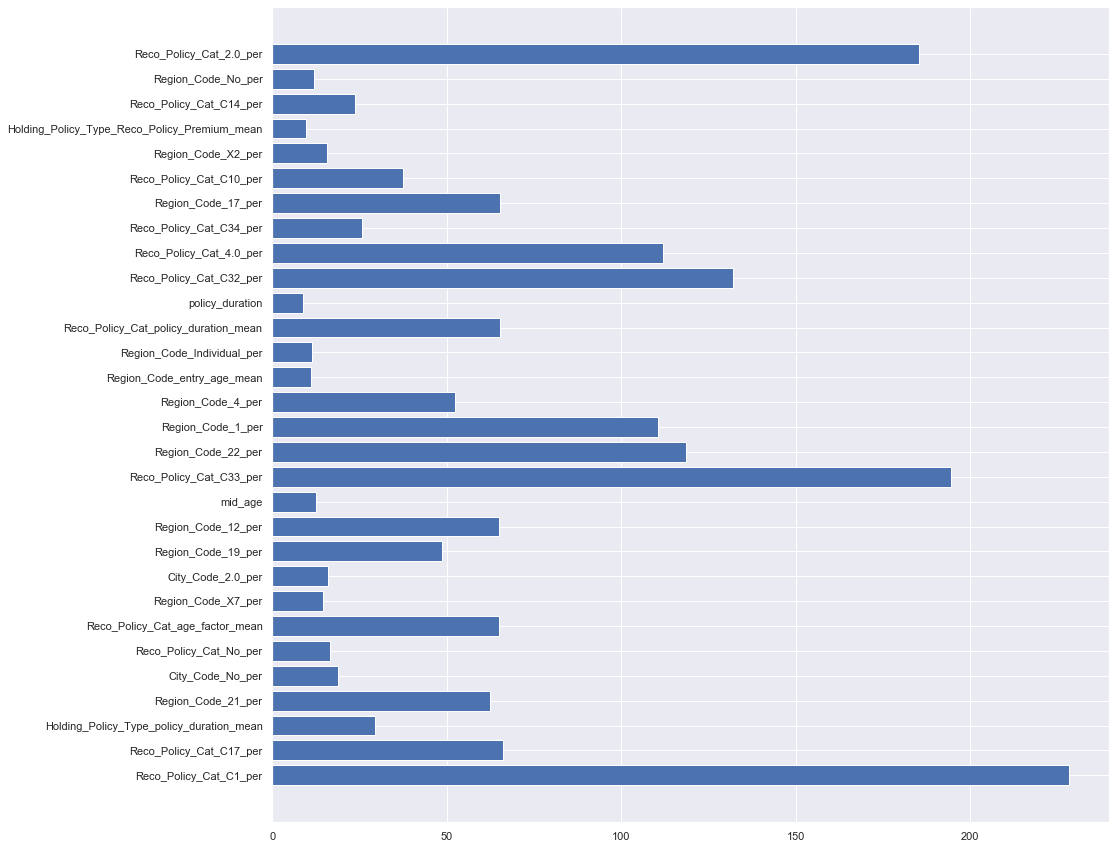

In [77]:
top_feature = 30
plt.figure(figsize=(15,15))
plt.barh(imp_score.head(top_feature).index,imp_score['score'].head(top_feature))